In [1]:
import warnings
warnings.filterwarnings('ignore',category=RuntimeWarning)
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os,sys
from tqdm.auto import tqdm
import proplot as plot
import json,pickle
import dask.array as da
import gc
from sklearn.decomposition import PCA
sys.path.insert(1, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/2020_TC_CRF/dev/freddy0218/')
from tools import derive_var,read_and_proc,preproc_noensemble
from tools.mlr import mlr,proc_mlrfcst,maria_IO
from tools.preprocess import do_eof,preproc_maria,preproc_haiyan
sys.path.insert(2, '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/')
import feature_select
from dask.distributed import Client
client = Client(processes=True, threads_per_worker=1,n_workers=2)
%matplotlib inline
plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',
                'tick.labelweight':'ultralight','gridminor.linestyle':'--','title.weight':'normal','linewidth':0.5})

/tmp/ipykernel_3684710/2472673958.py:24: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'figure.facecolor':'w','axes.labelweight':'ultralight',


#### Read data

In [2]:
path = '/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/'
suffix = '_smooth_preproc_dict1b_g'
a = [read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'].shape for lime in tqdm(range(1,21))]
# divide experiments reference
divider = np.asarray([aobj[0] for aobj in a]).cumsum()

haiyan_u = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['u'] for lime in tqdm(range(1,21))],axis=0)
haiyan_v = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['v'] for lime in tqdm(range(1,21))],axis=0)
haiyan_w = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['w'] for lime in tqdm(range(1,21))],axis=0)
haiyan_qv = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['qv'] for lime in tqdm(range(1,21))],axis=0)
haiyan_theta = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['theta'] for lime in tqdm(range(1,21))],axis=0)
haiyan_heatsum = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['heatsum'] for lime in tqdm(range(1,21))],axis=0)
haiyan_hdia = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['hdia'] for lime in tqdm(range(1,21))],axis=0)
haiyan_rad = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['rad'] for lime in tqdm(range(1,21))],axis=0)
#haiyan_ir = np.concatenate([read_and_proc.depickle(path+'TCGphy/testML/output/haiyan/processed/uvwheat/'+'mem'+str(lime)+suffix)['ir'] for lime in tqdm(range(1,21))],axis=0)

folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/haiyan/processed/'
PCAdict,dict2 = read_and_proc.depickle(folderpath+'pca/PCA'+'_'+'dict1_g'),read_and_proc.depickle(folderpath+'pca/PCA'+'_'+'dict2_g') #dict1: u,v,w,theta,hdia,rad; dict2:qv,ir
PCAdict['qv'] = (dict2['qv'])
PCAdict['ir'] = (dict2['ir'])

dims = ['sample','flatarray']
coords = dict(sample=np.linspace(0,haiyan_u.shape[0]-1,haiyan_u.shape[0]),flatarray=np.linspace(0,haiyan_u.shape[1]-1,haiyan_u.shape[1]))

ds = xr.Dataset(coords=coords)#,'heatsum','hdia','rad','qv','ir'],\
haiyan_data=preproc_haiyan.build_a_xarray_dataset(ds=ds,varname=['u','v','w','theta'],\
                                   varfile=[haiyan_u,haiyan_v,haiyan_w,haiyan_theta],dims=dims,coords=coords)
del haiyan_u,haiyan_v,haiyan_w,haiyan_theta,haiyan_heatsum,haiyan_hdia,haiyan_rad
gc.collect()

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

188

In [3]:
folderpath='/work/FAC/FGSE/IDYST/tbeucler/default/freddy0218/TCGphy/testML/output/haiyan/processed/'
Xtrain = read_and_proc.depickle(folderpath+'pca/X/Xtrain'+'_'+'dict_g')
Xvalid = read_and_proc.depickle(folderpath+'pca/X/Xvalid'+'_'+'dict_g')
Xtest = read_and_proc.depickle(folderpath+'pca/X/Xtest'+'_'+'dict_g')
yall = read_and_proc.depickle(folderpath+'pca/y/allY'+'_'+'dict_g')

#### Import real du/dv data (for R2)

In [4]:
def forward_diff(arrayin=None,delta=None,axis=None,LT=1):
    result = []
    if axis==0:
        for i in range(0,arrayin.shape[axis]-LT):
            temp = (arrayin[i+LT,:]-arrayin[i,:])/(LT*delta)
            result.append(temp)
        return np.asarray(result)
    
class retrieve_cartesian:
    def __init__(self,PCA_dict=None,Af_dict=None,numcomp=[11,11,15],LT=None,forecastPC=None,target='all',suffix=None):
        self.PCA_dict=PCA_dict
        self.numcomp=numcomp
        self.forecastPC = forecastPC
        self.LT = LT
        self.target=target
        self.suffix=suffix
        
    def get_time_diff_terms(self,inputvar=None,LT=None,wantvar=None):
        def _get_time_diff(array=None,timedelta=60*60,LT=None):
            store = []
            for exp in array:
                a = forward_diff(exp,timedelta,0,LT)
                if a.shape[0]>0:
                    azero = np.zeros((LT,exp.shape[-1]))
                    store.append(np.asarray(a))
                    #store.append(np.concatenate((a,azero),axis=0))
                else:
                    continue
                    #store.append(np.zeros((exp.shape[0],exp.shape[-1])))
            return store
        
        storedict = {}
        for wantvarZ,wantvarN in enumerate(wantvar):
            storedict[wantvarN] = _get_time_diff(array=inputvar[wantvarZ],LT=LT)
        return storedict
    
    def _pop_valid_test(self,examplist=None,validindex=None,testindex=None):
        [examplist.pop(i) for i in validindex]
        [examplist.pop(i) for i in testindex]
        return None
        
    def windrates_real(self,uvwheatpath=None,LT=None,category='train',validindex=[1,6],testindex=[2,12]):
        u = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['u'] for lime in tqdm(range(1,21))].copy()
        v = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['v'] for lime in tqdm(range(1,21))].copy()
        w = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['w'] for lime in tqdm(range(1,21))].copy()
        theta = [read_and_proc.depickle(path+uvwheatpath+'mem'+str(lime)+self.suffix)['theta'] for lime in tqdm(range(1,21))].copy()
        
        if category=='train':
            self._pop_valid_test(u,validindex,testindex)
            self._pop_valid_test(v,validindex,testindex)
            self._pop_valid_test(w,validindex,testindex)
            self._pop_valid_test(theta,validindex,testindex)
            assert len(u)==16, 'wrong train-valid-test separation!'
            dtermsT = self.get_time_diff_terms(inputvar=[u,v,w,theta],LT=LT,wantvar=['u','v','w','theta'])
        elif category=='valid':
            uv = [u[index] for index in validindex]
            vv = [v[index] for index in validindex]
            wv = [w[index] for index in validindex]
            thetav = [theta[index] for index in validindex]
            del u,v,w,theta
            gc.collect()
            dtermsT = self.get_time_diff_terms(inputvar=[uv,vv,wv,thetav],LT=LT,wantvar=['u','v','w','theta'])
        elif category=='test':
            ut = [u[index] for index in testindex]
            vt = [v[index] for index in testindex]
            wt = [w[index] for index in testindex]
            thetat = [theta[index] for index in testindex]            
            del u,v,w,theta
            gc.collect()
            dtermsT = self.get_time_diff_terms(inputvar=[ut,vt,wt,thetat],LT=LT,wantvar=['u','v','w','theta'])            
        
        dudt = np.concatenate([testx for testx in dtermsT['u']],axis=0)
        dvdt = np.concatenate([testx for testx in dtermsT['v']],axis=0)
        dwdt = np.concatenate([testx for testx in dtermsT['w']],axis=0)
        dthdt = np.concatenate([testx for testx in dtermsT['theta']],axis=0)
        del dtermsT
        gc.collect()
        return dudt,dvdt,dwdt,dthdt
    
    def output_reshapeRECON(self,forecast_eig=None):
        if (self.target=='surface') or (self.target=='alluv'):
            testrec_dudt = np.dot(forecast_eig[:,0:self.numcomp[0]],(self.PCA_dict['u'].components_[0:self.numcomp[0]]))#.reshape((91,39,360,167))
            testrec_dvdt = np.dot(forecast_eig[:,self.numcomp[0]:self.numcomp[0]+self.numcomp[1]],(self.PCA_dict['v'].components_[0:self.numcomp[1]]))#.reshape((91,39,360,167))
            return testrec_dudt,testrec_dvdt
        else:
            testrec_dudt = np.dot(forecast_eig[:,0:self.numcomp[0]],(self.PCA_dict['u'].components_[0:self.numcomp[0]]))#.reshape((91,39,360,167))
            testrec_dvdt = np.dot(forecast_eig[:,self.numcomp[0]:self.numcomp[0]+self.numcomp[1]],(self.PCA_dict['v'].components_[0:self.numcomp[1]]))#.reshape((91,39,360,167))
            testrec_dwdt = np.dot(forecast_eig[:,self.numcomp[0]+self.numcomp[1]:self.numcomp[0]+self.numcomp[1]+self.numcomp[2]],(self.PCA_dict['w'].components_[0:self.numcomp[2]]))#.reshape((39,360,167))
            testrec_dthdt = np.dot(forecast_eig[:,self.numcomp[0]+self.numcomp[1]+self.numcomp[2]:],(self.PCA_dict['theta'].components_[0:self.numcomp[3]]))#.reshape((39,360,167))
            return testrec_dudt,testrec_dvdt,testrec_dwdt,testrec_dthdt
        
    def conversion_predictPC(self,yforecast=None,mshpe=[39,360,167]):
        if self.target=='surface':
            t1,t2 = self.output_reshapeRECON(forecast_eig=yforecast)
            return (t1.reshape(t1.shape[0],mshpe[0],mshpe[1],mshpe[2])[:,0,:,:]).reshape(t1.shape[0],mshpe[1]*mshpe[2]),(t2.reshape(t2.shape[0],mshpe[0],mshpe[1],mshpe[2])[:,0,:,:]).reshape(t2.shape[0],mshpe[1]*mshpe[2])
        elif self.target=='alluv':
            t1,t2 = self.output_reshapeRECON(forecast_eig=yforecast)
            return t1,t2
        elif self.target=='all': 
            t1,t2,t3,t4 = self.output_reshapeRECON(forecast_eig=yforecast)
            return t1,t2,t3,t4
        
    def output_r2(self,FFWmodels=None,reducedX=None,realU=None,realV=None,realW=None,realTH=None,case='Haiyan'):
        yf = [models.predict(Xns) for (models,Xns) in zip(FFWmodels[:],reducedX[:])]
        mlr_r2 = []
        for i in (range(45)):#len(yf))):
            if case=='Maria':
                temp1,temp2 = self.conversion_predictPC(yforecast=yf[i],mshpe=[39,360,167])
                mlr_r2.append(r2_score(np.concatenate((realU,realV),axis=0),np.concatenate((temp1,temp2),axis=0)))
            elif case=='Haiyan':
                try:
                    temp1,temp2 = self.conversion_predictPC(yforecast=yf[i],mshpe=[10,360,208])
                    a = r2_score(np.concatenate((realU,realV),axis=0),np.concatenate((temp1,temp2),axis=0))
                    print(a)
                    mlr_r2.append(a)
                except:
                    temp1,temp2,temp3,temp4 = self.conversion_predictPC(yforecast=yf[i],mshpe=[10,360,208])
                    a = r2_score(np.concatenate((realU,realV,realW,realTH),axis=0),np.concatenate((temp1,temp2,temp3,temp4),axis=0))
                    print(a)
                    mlr_r2.append(a)
            del temp1,temp2
            gc.collect()
        return mlr_r2

In [5]:
def output_realdterms(category='train',varnum=2,LT=24):
    if varnum==2:
        a,b,_,_ = retrieve_cartesian(PCA_dict=None,Af_dict=haiyan_data,numcomp=None,LT=24,forecastPC=None,\
                                  target='all',suffix=suffix).windrates_real(uvwheatpath='TCGphy/testML/output/haiyan/processed/uvwheat/',\
                                                                             LT=LT,category=category,validindex=[1,6],testindex=[2,12])
        return a,b
    elif varnum==4:
        a,b,c,d = retrieve_cartesian(PCA_dict=None,Af_dict=haiyan_data,numcomp=None,LT=24,forecastPC=None,\
                                  target='all',suffix=suffix).windrates_real(uvwheatpath='TCGphy/testML/output/haiyan/processed/uvwheat/',\
                                                                             LT=LT,category=category,validindex=[1,6],testindex=[2,12])     
        return a,b,c,d
lti=24
realdu,realdv,realdw,realdtheta = output_realdterms(category='train',varnum=4,LT=lti)
#realdu_valid,realdv_valid,realdw_valid,realdtheta_valid = output_realdterms(category='valid',varnum=4,LT=lti)
#realdu_test,realdv_test,realdw_test,realdtheta_test = output_realdterms(category='test',varnum=4,LT=lti)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [6]:
realsurfu,realsurfv = realdu.reshape(realdu.shape[0],10,360,208)[:,0,:,:].reshape(realdu.shape[0],360*208),realdv.reshape(realdv.shape[0],10,360,208)[:,0,:,:].reshape(realdu.shape[0],360*208)
#realsurfu_valid,realsurfv_valid = realdu_valid.reshape(realdu_valid.shape[0],10,360,208)[:,0,:,:].reshape(realdu_valid.shape[0],360*208),realdv_valid.reshape(realdv_valid.shape[0],10,360,208)[:,0,:,:].reshape(realdu_valid.shape[0],360*208)
#realsurfu_test,realsurfv_test = realdu_test.reshape(realdu_test.shape[0],10,360,208)[:,0,:,:].reshape(realdu_test.shape[0],360*208),realdv_test.reshape(realdv_test.shape[0],10,360,208)[:,0,:,:].reshape(realdu_test.shape[0],360*208)

In [7]:
from sklearn.feature_selection import SelectorMixin
from sklearn.metrics import r2_score
from sklearn.base import BaseEstimator, MetaEstimatorMixin, clone
from sklearn.model_selection import cross_val_score
import numpy as np
import gc
import importlib
importlib.reload(proc_mlrfcst)
importlib.reload(mlr)

class forwardfeatureadder(BaseEstimator,SelectorMixin,MetaEstimatorMixin):
    """Transformer to add feature at a sequential order
    Parameters:
    estimator: Regression model
    n_features_to_select: number of features to add to the model
    cv: how many folds would we want during cross-validation
    n_jobs: Parallelization
    startfeatures: Features we would like to include in the model without cross-validation [we do this to accentuate the role of heating]
    
    Output:
    self instance
    """
    def __init__(self,estimator,n_features_to_select=None,cv=5,n_jobs=None,startfeatures=None,PCAdict=None,Afdict=None,numcomp=None,LT=None,optigoal='surface',Xsurf=None,Ysurf=None):
        self.estimator = estimator
        self.n_features_to_select = n_features_to_select
        self.cv = cv
        self.n_jobs = n_jobs
        self.startfeatures = startfeatures
        self.PCAdict = PCAdict
        self.Afdict = Afdict
        self.numcomp = numcomp
        self.LT = LT
        self.optigoal = optigoal
        self.Xsurf=Xsurf
        self.Ysurf=Ysurf
    
    def get_real_winds(self):
        temp1,temp2,temp3,temp4 = proc_mlrfcst.retrieve_cartesian(PCA_dict=self.PCAdict,Af_dict=self.Afdict,numcomp=self.numcomp,LT=self.LT,
                            forecastPC=None).windrates_real(LT=self.LT)
        return temp1,temp2,temp3,temp4
    
    def convert_forecast_winds(self,yforecast=None):
        try:
            temp1,temp2,temp3,temp4 = proc_mlrfcst.retrieve_cartesian(PCA_dict=self.PCAdict,Af_dict=self.Afdict,numcomp=self.numcomp,LT=self.LT,
                                                                      forecastPC=yforecast).output_reshapeRECON(forecast_eig=yforecast[int(self.LT[i]-1)])
            return temp1,temp2,temp3,temp4
        except:
            temp1,temp2 = proc_mlrfcst.retrieve_cartesian(PCA_dict=self.PCAdict,Af_dict=self.Afdict,numcomp=self.numcomp,LT=self.LT,
                                                                      forecastPC=yforecast,target='surface').output_reshapeRECON(forecast_eig=yforecast)        
            return temp1,temp2
    
    def fit(self, X,y=None):
        """Learn features to select from X.
        X (n_samples,n_features): Training vectors
        Y (n_samples): Target values
        """
        # Define basic settings
        n_features = X.shape[1]
        current_mask = np.zeros(shape=n_features,dtype=bool)
        for index in self.startfeatures:
            current_mask[index] = True
        n_iteractions = self.n_features_to_select
        
        # Do forward selection
        addinput,r2 = [],[]
        clone_estimator = clone(self.estimator)
        for _ in range(n_iteractions):
            #new_feature_idx,r2t = self.get_best_new_feature_R2based(clone_estimator,X,y,current_mask)
            new_feature_idx = self.get_best_new_feature(clone_estimator,X,y,current_mask)
            #r2.append(r2t)
            current_mask[new_feature_idx] = True
            addinput.append(current_mask)
        
        self.support_ = current_mask
        self.new_feature = new_feature_idx
        self.r2 = r2
        return self
    
    def get_best_new_feature(self,estimator,X,y,current_mask):
        candidate_feature_indices = np.flatnonzero(~current_mask)
        scores={}
        for feature_idx in candidate_feature_indices:
            candidate_mask = current_mask.copy()
            candidate_mask[feature_idx] = True
            
            # Add a new feature
            X_new = X[:,candidate_mask]
            # Improvement
            scores[feature_idx] = cross_val_score(estimator,X_new,y,cv=self.cv,scoring=None,n_jobs=self.n_jobs).mean()
        return max(scores,key=lambda feature_idx: scores[feature_idx])
    
    #--------------------------------------------------------------
    # To do -> Add featureselector based on r2
    # Candidate mask -> Xnew
    # fit linear model with (Xnew,y)
    # {output r2 term [time consideration => target: surface u/v]}...repeat for all u/v/w/theta members
    # get component index that results in best r2 score
    # --------[[Exit loops when r2 reaches 0.75?]]-----------------
    # add to mask during fitting 
    #---------------------------------------------------------------------------------------------------
    def get_best_new_feature_R2based(self,estimator,X,y,current_mask):             
        candidate_feature_indices = np.flatnonzero(~current_mask)
        scores={}
        for feature_idx in candidate_feature_indices:
            candidate_mask = current_mask.copy()
            candidate_mask[feature_idx] = True
            # Add a new feature
            X_new = X[:,candidate_mask]
            # Improvement
            LDTME = np.linspace(0,44,45)+1
            y_forecast = mlr.model_fitpredict(X_new,y,estimator,LDTME).modelfit(singleLT=True)[0].predict(X_new)
            #################################################################################################################################################################################################################
            # Forecast winds
            #################################################################################################################################################################################################################
            if self.optigoal=='surface':
                teMP1,teMP2 = self.convert_forecast_winds(y_forecast)
                teMP1s,teMP2s = (teMP1.reshape(teMP1.shape[0],39,360,167)[:,0,:,:]).reshape(teMP1.shape[0],360*167),(teMP2.reshape(teMP2.shape[0],39,360,167)[:,0,:,:]).reshape(teMP2.shape[0],360*167)
                del teMP1,teMP2
                gc.collect()
                scores[feature_idx] = r2_score(np.concatenate((self.Xsurf,self.Ysurf),axis=0),np.concatenate((teMP1s,teMP2s),axis=0))
            else:
                teMP1,teMP2,teMP3,teMP4 = self.convert_forecast_winds(y_forecast)                
                scores[feature_idx] = r2_score(np.concatenate((reteMP1,reteMP2,reteMP3,reteMP4),axis=0),np.concatenate((teMP1,teMP2,teMP3,teMP4),axis=0))
        return max(scores,key=lambda feature_idx: scores[feature_idx]),max(scores.values())
    
    def _get_support_mask(self):
        return self.support_

#### Train

In [8]:
from sklearn.linear_model import LinearRegression
# Initiate model
nummem = [50,38,91,8]#[54,26,50,75]
linreg = LinearRegression()
lti = 24
ytrain = [yobj[0] for yobj in yall]
mlrIN,mlrOUT = mlr.SimpleIOhandler(LT=lti,auxIN=None).transform(Xtrain['dtthuvwqv'],ytrain)

In [9]:
model,reducedX,new_feature = [],[],[]
holdmem = [int(obj) for obj in np.linspace(269+28,289-1+28,20)]#[int(obj) for obj in np.linspace(269,289-1,20)]
for i in tqdm(range(120)):#np.asarray(mlrIN).shape[1]-20)):
    seq_temp = forwardfeatureadder(linreg,1,9,4,holdmem,\
                                   PCAdict,haiyan_data,nummem,lti,'surface',None,None).fit(np.asarray(mlrIN),mlrOUT)
    holdmem.append(seq_temp.new_feature)
    new_feature.append(seq_temp.new_feature)
    Xn = seq_temp.transform(np.asarray(mlrIN)) #Remove unimportant features
    ridge_reduced = LinearRegression().fit(Xn,mlrOUT) #Train model with reduced input
    model.append(ridge_reduced)
    reducedX.append(Xn)

  0%|          | 0/120 [00:00<?, ?it/s]

In [10]:
read_and_proc.save_to_pickle('../../output/haiyan/processed/pca/FFW/'+str(lti)+'/FFWmodels_cross7_withQV',model,'PICKLE')
read_and_proc.save_to_pickle('../../output/haiyan/processed/pca/FFW/'+str(lti)+'/newfeature_cross7_withQV',new_feature,'PICKLE')
read_and_proc.save_to_pickle('../../output/haiyan/processed/pca/FFW/'+str(lti)+'/reducedX_cross7_withQV',reducedX,'PICKLE')

#### Read saved models

In [9]:
lti = 24
model = read_and_proc.depickle('../../output/haiyan/processed/pca/FFW/'+str(lti)+'/FFWmodels_cross7')
new_feature = read_and_proc.depickle('../../output/haiyan/processed/pca/FFW/'+str(lti)+'/newfeature_cross7')
reducedX = read_and_proc.depickle('../../output/haiyan/processed/pca/FFW/'+str(lti)+'/reducedX_cross7')

model_c3 = read_and_proc.depickle('../../output/haiyan/processed/pca/FFW/'+str(lti)+'/FFWmodels_cross5')
new_feature_c3 = read_and_proc.depickle('../../output/haiyan/processed/pca/FFW/'+str(lti)+'/newfeature_cross5')
reducedX_c3 = read_and_proc.depickle('../../output/haiyan/processed/pca/FFW/'+str(lti)+'/reducedX_cross5')

In [11]:
nummem = [50,38,91,8]
r2_train = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=haiyan_data,numcomp=nummem,LT=lti,forecastPC=None,target='surface',\
                              suffix=suffix).output_r2(FFWmodels=model,reducedX=reducedX,realU=realsurfu,realV=realsurfv,case='Haiyan')
#r2_train = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=haiyan_data,numcomp=nummem,LT=lti,forecastPC=None,target='alluv',\
#                              suffix=suffix).output_r2(FFWmodels=model,reducedX=reducedX,realU=realdu,realV=realdv,case='Haiyan')
#r2_train = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=haiyan_data,numcomp=nummem,LT=lti,forecastPC=None,target='all',\
#                              suffix=suffix).output_r2(FFWmodels=model,reducedX=reducedX,realU=realdu,realV=realdv,realW=realdw,realTH=realdtheta,case='Haiyan')

0.5565998681616509
0.5621922652471542
0.5707531279899404
0.577173978150082
0.5840301255032883
0.5945174223669435
0.6027966032110958
0.6141009018646814
0.6247718679283945
0.6357609336785417
0.6376427067206368
0.6418588153736358
0.6480165425611092
0.653409451189462
0.6602874032468264
0.6645882538249069
0.6688344951994702
0.6746728567292053
0.681530183770244
0.6859265660397136
0.6896986291829137
0.6953648095063776
0.7059631813660108
0.7100828879485948
0.7144922133596067
0.7182393594146927
0.7212063510941954
0.7247974367278055
0.7311420069355471
0.7350570537989262
0.7367456143444868
0.7408652935530304
0.7430172059473072
0.7466874190379343
0.7491524031006864
0.7523482088119549
0.7537036258327567
0.7577733814341647
0.7626353807095357
0.766479242352997
0.7682387002653639
0.7699319637032229
0.7720739872564132
0.7751625909767728
0.7763041808574642


#### Valid

In [19]:
realdu_valid,realdv_valid,realdw_valid,realdtheta_valid = output_realdterms(category='valid',varnum=4,LT=lti)
realsurfu_valid,realsurfv_valid = realdu_valid.reshape(realdu_valid.shape[0],10,360,208)[:,0,:,:].reshape(realdu_valid.shape[0],360*208),realdv_valid.reshape(realdv_valid.shape[0],10,360,208)[:,0,:,:].reshape(realdu_valid.shape[0],360*208)
yvalid = [yobj[1] for yobj in yall]
mlrIN_v,mlrOUT_v = mlr.SimpleIOhandler(LT=lti,auxIN=None).transform(Xvalid['dtthuvwqv'],yvalid)

loc = [int(obj) for obj in list(np.transpose(np.linspace(269,289-1,20)))]
loopfeature = [np.asarray(loc.copy())]
for i in range(len(new_feature)):
    loopfeature.append(np.append(loopfeature[i],new_feature[i]))
    
reducedX_valid = [np.asarray(mlrIN_v)[:,sorted(loopfeature[i])] for i in range(len(loopfeature))]
r2_valid = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=haiyan_data,numcomp=nummem,LT=lti,forecastPC=None,target='surface',\
                              suffix=suffix).output_r2(FFWmodels=model,reducedX=reducedX_valid[1:],realU=realsurfu_valid,\
                                                       realV=realsurfv_valid,case='Haiyan')
#r2_valid = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=haiyan_data,numcomp=nummem,LT=lti,forecastPC=None,target='alluv',\
#                              suffix=suffix).output_r2(FFWmodels=model,reducedX=reducedX_valid[1:],realU=realdu_valid,\
#                                                       realV=realdv_valid,case='Haiyan')
#realdu_valid,realdv_valid,realdw_valid,realdtheta_valid = output_realdterms(category='valid',varnum=4,LT=lti)
#realdu_test,realdv_test,realdw_test,realdtheta_test = output_realdterms(category='test',varnum=4,LT=lti)#r2_valid = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=haiyan_data,numcomp=
#nummem,LT=lti,forecastPC=None,target='all',\
#                              suffix=suffix).output_r2(FFWmodels=model_c3,reducedX=reducedX_valid[1:],realU=realdu_valid,realW=realdw_valid,realTH=realdtheta_valid,\
#                                                       realV=realdv_valid,case='Haiyan')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-0.1221760348094605
-0.1103255254432459
-0.06089837430902038
-0.11152519289922137
-0.1423669259559389
-0.15859859584512107
-0.17110598999739235
-0.19889293665582827
-0.40429037974950344
-0.4967639964700713
-0.48762455335296134
-0.4762958726717573
-0.46377056506842546
-0.525972188459607
-0.4048907554395211
-0.3585141485358765
-0.31260164606650964
-0.32609318474540255
-0.3233105948370659
-0.34134350391804524
-0.2545777709998859
-0.15108675899310878
-0.15475627765176295
-0.14256506251185486
-0.5726360084368289
-0.5517736767496115
-0.5708356927009726
-0.5878253884615654
-0.5168717293781995
-0.5729747257142995
-0.5862993091411903
-0.7062556578392508
-0.6809291779700579
-0.7214067597385022
-0.8551425886337841
-0.8047229315274047
-0.7938492177948746
-0.7817010278658129
-0.7115302615221919
-0.7192992239214472
-0.7274455657256105
-0.7717041874359095
-0.7971933662408687
-0.8929845332254657
-0.885332280228222


#### Test

In [21]:
realdu_test,realdv_test,realdw_test,realdtheta_test = output_realdterms(category='test',varnum=4,LT=lti)
realsurfu_test,realsurfv_test = realdu_test.reshape(realdu_test.shape[0],10,360,208)[:,0,:,:].reshape(realdu_test.shape[0],360*208),realdv_test.reshape(realdv_test.shape[0],10,360,208)[:,0,:,:].reshape(realdu_test.shape[0],360*208)
ytest = [yobj[2] for yobj in yall]
mlrIN_v,mlrOUT_v = mlr.SimpleIOhandler(LT=lti,auxIN=None).transform(Xtest['dtthuvwqv'],ytest)
    
reducedX_test = [np.asarray(mlrIN_v)[:,sorted(loopfeature[i])] for i in range(len(loopfeature))]
r2_test = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=haiyan_data,numcomp=nummem,LT=lti,forecastPC=None,target='surface',\
                              suffix=suffix).output_r2(FFWmodels=model,reducedX=reducedX_test[1:],realU=realsurfu_test,realV=realsurfv_test,case='Haiyan')
#r2_test = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=haiyan_data,numcomp=nummem,LT=lti,forecastPC=None,target='alluv',\
#                              suffix=suffix).output_r2(FFWmodels=model,reducedX=reducedX_test[1:],realU=realdu_test,realV=realdv_test,case='Haiyan')
#r2_test = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=haiyan_data,numcomp=nummem,LT=lti,forecastPC=None,target='alluv',\
#                              suffix=suffix).output_r2(FFWmodels=model,reducedX=reducedX_test[1:],realU=realdu,realW=realdw,realTH=realdtheta,\
#                                                       realV=realdv_valid,case='Haiyan')
#r2_test = retrieve_cartesian(PCA_dict=PCAdict,Af_dict=haiyan_data,numcomp=nummem,LT=lti,forecastPC=None,target='all',\
#                              suffix=suffix).output_r2(FFWmodels=model_c3,reducedX=reducedX_test[1:],realU=realdu_test,realW=realdw_test,realTH=realdtheta_test,\
#                                                       realV=realdv_test,case='Haiyan')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-0.005384944011221521
0.03605816273857301
0.10351353786010667
0.15458504227158024
0.16239736742175762
0.1740101248452116
0.17807765000018466
0.1942698429288418
0.2920621810407444
0.2494784202870293
0.24837249923100288
0.2540784571872358
0.24314685311392747
0.2465755562360446
0.16528759245713556
0.1758295129693401
0.17604697904326091
0.16719664918166607
0.13747285002760254
0.09865901764404246
0.18854160696946157
0.1658766997141171
0.18297360577236987
0.19087058150805666
0.012786964734431841
0.009606162866688745
0.015503384076893917
0.03165590161771132
0.04103524462323785
-0.009254926650079523
-0.013033254387880147
-0.06968459858479928
-0.07282013858330999
-0.10474516666806728
-0.10590216929655602
0.06470959952620396
0.06594002687532952
0.019184655242063666
-0.0010867528038749443
-0.03133461439335727
-0.02839225483937691
-0.017907954668331387
-0.048123716931895
-0.0746660409353466
-0.04663157930025619


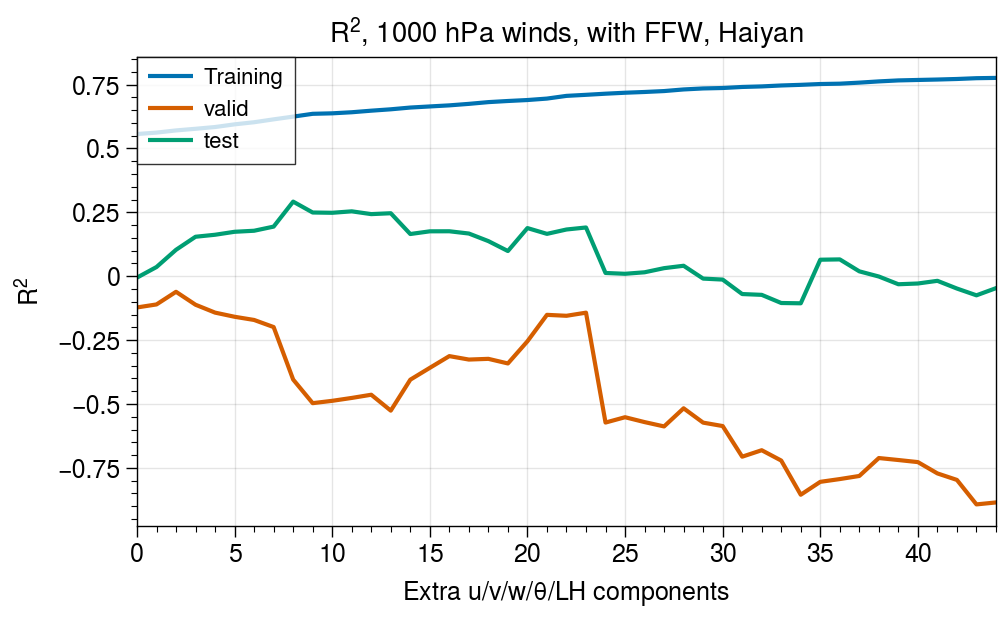

In [22]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
axs[0].plot(r2_train,label='Training')
axs[0].plot(r2_valid,label='valid')
axs[0].plot(r2_test,label='test')
axs.legend(loc='ul',prop={'size':8},ncols=1)
axs[0].format(xlabel=r'Extra u/v/w/$\theta$/LH components',ylabel='R$^{2}$',title='R$^{2}$, 1000 hPa winds, with FFW, Haiyan')
#plt.savefig('../../figures/0406/r2_withFFW_haiyan.png',dpi=300)
plt.show()

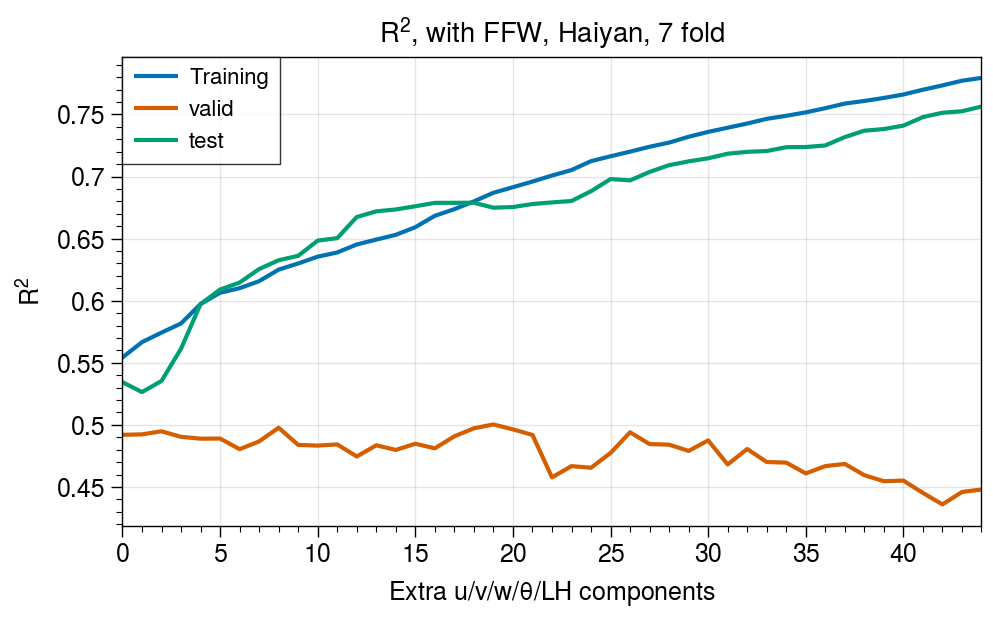

In [19]:
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.295,refaspect=1.831)
axs[0].plot(r2_train,label='Training')
axs[0].plot(r2_valid,label='valid')
axs[0].plot(r2_test,label='test')
axs.legend(loc='ul',prop={'size':8},ncols=1)
axs[0].format(xlabel=r'Extra u/v/w/$\theta$/LH components',ylabel='R$^{2}$',title='R$^{2}$, uv winds, with FFW, Haiyan, 7 fold, 6 Hr FW')
plt.savefig('../../figures/0406/r2_withFFW_haiyan_alluv_7fold_6hr.png',dpi=300)
plt.show()

In [23]:
def feature_importance_from_mlr(MODEL=None,smallX=None):
    def _get_feature_importance(WEIGHTx=None,smallXx=None):
        return np.nanmean(np.asarray([temp*smallXx for temp in WEIGHTx]),axis=1)
    weight = MODEL.coef_
    #WEIGHTZ = np.zeros_like(weight)
    return np.asarray([_get_feature_importance(weight[:,weightz],smallX[:,weightz]) for weightz in range(smallX.shape[1])])
ensemble_weights = [feature_importance_from_mlr(MODEL=model[i],smallX=reducedX[i]) for i in range(10)]

/tmp/ipykernel_3684710/3221861949.py:3: ProplotWarning: rc setting 'linewidth' was renamed to 'meta.width' in version 0.8.
  plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','title.color':'w','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})


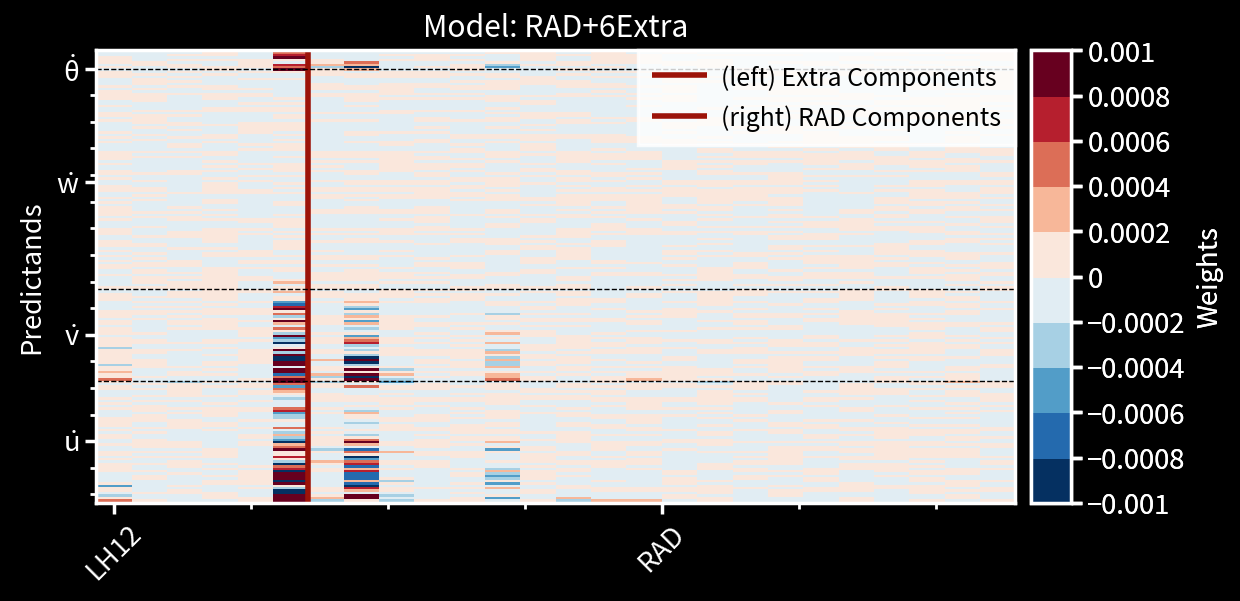

In [24]:
i=5
plot.rc.metacolor = 'w'
plot.rc.update({'axes.labelweight':'normal','tick.labelweight':'normal','figure.facecolor':'k','title.color':'w','fontname': 'Source Sans Pro', 'fontsize': 11,'linewidth':1.25})
plot.rc.axesfacecolor = 'k'
from matplotlib.lines import Line2D
fig,axs = plot.subplots(ncols=1,nrows=1,axwidth=4.595,refaspect=2.031)
l = axs[0].pcolormesh(np.linspace(0,20+i,21+i)-0.5,np.linspace(0,186,187),ensemble_weights[i].transpose(),cmap='BuRd',vmin=-0.001,vmax=0.001)
#axs.format(ylabel='Predictands',xticks=[-0.5,1-0.5,2-0.5,3-0.5,4-0.5,5-0.5,10+i],yticks=[25,69,132,179],yticklabels=['$\dot{u}$','$\dot{v}$','$\dot{w}$',r'$\dot{\theta}$'],\
#          xticklabels=['U8','U27','V22','LH5','LH8','LH12','RAD'],title=f'Model: RAD+{i+1}Extra')
axs.format(ylabel='Predictands',xticks=[-0.5,10+i],yticks=[25,69,132,179],yticklabels=['$\dot{u}$','$\dot{v}$','$\dot{w}$',r'$\dot{\theta}$'],\
          xticklabels=['LH12','RAD'],title=f'Model: RAD+{i+1}Extra')
l2 = axs[0].axvline(i,lw=2,color='#9c1309')
for ix in [50,88,179]:
    axs[0].axhline(ix,lw=0.5,color='k',ls='--')
custom_lines = [Line2D([0], [0], color='#9c1309', lw=2),Line2D([0], [0], color='#9c1309', lw=2)]
axs[0].legend(custom_lines, ['(left) Extra Components', '(right) RAD Components'],loc='ur',ncols=1,prop={'size':10})
plt.colorbar(l,ax=axs[0],label='Weights')
for tick in axs[0].get_xticklabels():
    tick.set_rotation(45)
#plt.savefig('../figures/0430/weights_'+str(i)+'.png',dpi=300,facecolor=fig.get_facecolor())
plt.show()